In [28]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


In [29]:
# Function to create transects by selecting points around target theta2 values
def create_transects_around_target_theta2(point_cloud, target_theta2_values, theta_range=1.5):
    return [point_cloud[(point_cloud['theta'] >= target_theta2 - theta_range) & 
                        (point_cloud['theta'] <= target_theta2 + theta_range)] 
            for target_theta2 in target_theta2_values]

# Function to check if all values in the point_cloud_df have been assigned to a transect
def check_unassigned_points(point_cloud_df, transects):
    assigned_points = pd.concat(transects)
    return point_cloud_df[~point_cloud_df.index.isin(assigned_points.index)].shape[0]

In [30]:
def singe_file(pcd_file_path):
    pcd = o3d.io.read_point_cloud(pcd_file_path)
    # create function that does all the above steps
    # Extract points as a NumPy array
    xyz = np.asarray(pcd.points)

    # Convert to spherical coordinates with the z-axis as the reference axis
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    rho = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta_degrees = np.degrees(np.arccos(z / rho))

    # Create a DataFrame to store the point cloud data along with theta values
    point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

    # Define the target theta2 values for each transect
    target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

    # Generate transects with theta2 values around the specified target values with increased range
    transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=1)

    # Rename the transects starting from 1 going to 16
    transect_names = [f'Transect {i}' for i in range(1, 17)]
    transect_dict = dict(zip(transect_names, transects))

    # Check for unassigned points
    unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
    if unassigned_points_count > 0:
        print(f"Unassigned points count: {unassigned_points_count}")

    # Remove the 'theta' column from each transect DataFrame
    for name in transect_dict:
        transect_dict[name] = transect_dict[name].drop(columns=['theta'])

    # Select Transect 3 for transformation
    A = 3
    transect_A = transect_dict[f'Transect {A}']

    # Convert transect DataFrame to NumPy array
    transect_xyz = transect_A[['x', 'y', 'z']].values

    # Apply the transformation matrix
    transect_xyz_homogeneous = np.hstack((transect_xyz, np.ones((transect_xyz.shape[0], 1))))
    transect_xyz_transformed = transect_xyz_homogeneous.dot(transformation_matrix.T)[:, :3]

    # Create a DataFrame for the transformed transect
    transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

    # Compute the translation back offsets for X and Y only
    translation_back = np.eye(4)
    translation_back[0, 3] = -transformation_matrix[0, 3]
    translation_back[1, 3] = -transformation_matrix[1, 3]

    # Apply the translation back to the origin for X and Y
    transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
    transect_xyz_transformed = transect_xyz_homogeneous.dot(translation_back.T)[:, :3]
    transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

    # Coordinates of the two points in the RD-coordinate system
    point2 = np.array([72465.165, 452065.649, 4.530, 1])  # S3 plaatTopHoek3
    point1 = np.array([72479.379, 452085.167, 4.598, 1])  # S3 plaatTopHoek4

    # Compute the direction vector
    direction = point1 - point2

    # Project the direction vector onto the XY-plane
    direction_xy = direction[:2]  # Only consider the X and Y components

    # Compute the angle to the Y-axis
    angle = np.arctan2(direction_xy[0], direction_xy[1])  # atan2(X, Y)

    # Construct the rotation matrix for rotation around the Z-axis
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0, 0],
        [np.sin(angle),  np.cos(angle), 0, 0],
        [0,              0,             1, 0],
        [0,              0,             0, 1]
    ])

    # Apply the rotation and translation matrix to the two points
    new_point1 = np.dot(translation_back, point1)
    new_point2 = np.dot(translation_back, point2)
    new_point1 = np.dot(rotation_matrix, new_point1)
    new_point2 = np.dot(rotation_matrix, new_point2)

    # Compute the new baseline axis
    baseline_axis = np.mean([new_point1[0], new_point2[0]])

    # Apply the rotation matrix to the point cloud
    transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
    transect_xyz_transformed = transect_xyz_homogeneous.dot(rotation_matrix.T)[:, :3]
    transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

     # remove points between z= [z1,z2], x=[x1,x2]
    transect_transformed_df = transect_transformed_df[(transect_transformed_df['z'] < z1) | (transect_transformed_df['z'] > z2) | (transect_transformed_df['x'] < x1) | (transect_transformed_df['x'] > x2)]
    # remove points above z=6
    transect_transformed_df = transect_transformed_df[transect_transformed_df['z'] < 6]
    
    # Translate the point cloud to align with the baseline axis
    transect_transformed_df['x'] = transect_transformed_df['x'] - baseline_axis + 100

    # remove all points after x=105
    transect_transformed_df = transect_transformed_df[transect_transformed_df['x'] < 105]
    # add point x=107, z=4.96
    new_point = pd.DataFrame({'x': [107], 'y': [0], 'z': [4.96]})
    transect_transformed_df = pd.concat([transect_transformed_df, new_point], ignore_index=True)
        
    return transect_transformed_df




In [31]:
# Define the transformation matrix gathered from CloudCompare georeferencing
transformation_matrix = np.array([
    [-0.000024980998,  0.000812676153, -0.000583815563,  492.143829345703],
    [ 0.000007067249, -0.000583839603, -0.000813012011,  127.397300720215],
    [-0.001000616350, -0.000024412553,  0.000008833092,    4.558271408081],
    [ 0.000000000000,  0.000000000000,  0.000000000000,    1.000000000000]
])

transformation_matrix[0,3]+=  72000.00 
transformation_matrix[1,3]+=  452000.00
transformation_matrix[3,3]=1

# to be removed area
z1 ,z2,x1,x2= 1.6 , 5.5, -0.9, 0.2 

print(transformation_matrix)

print(72494.97-transformation_matrix[0,3]-14.55+100)	
print(72504.20-transformation_matrix[0,3]-14.55+100)

[[-2.49809980e-05  8.12676153e-04 -5.83815563e-04  7.24921438e+04]
 [ 7.06724900e-06 -5.83839603e-04 -8.13012011e-04  4.52127397e+05]
 [-1.00061635e-03 -2.44125530e-05  8.83309200e-06  4.55827141e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
88.27617065429804
97.50617065429397


In [32]:
# pcd_file1 = r"U:\Data\2024-12-22, Storm 2\Lidars\20241223_LiDAR2\10s interval data\Lidar2__Pcl_0021_12_2024__16_20_30.064.PCD"
# pcd_file2 = r"U:\Data\2024-12-22, Storm 2\Lidars\20241223_LiDAR2\10s interval data\Lidar2__Pcl_0022_12_2024__10_23_20.062.PCD"
# pcd_file5 = r"U:\Data\2024-12-22, Storm 2\Lidars\20241223_LiDAR2\10s interval data\Lidar2__Pcl_0023_12_2024__12_06_30.062.PCD"

In [33]:
# Load point clouds
pcd_file1 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0021_12_2024__16_20_48.030.PCD"
pcd_file2 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0022_12_2024__11_23_20.780.PCD"
pcd_file5 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0023_12_2024__15_06_30.030.PCD"

# Process each point cloud through the singe_file function
df1 = singe_file(pcd_file1)
df2 = singe_file(pcd_file2)
# df3 = singe_file(pcd_file3)
# df4 = singe_file(pcd_file4)
df5 = singe_file(pcd_file5)


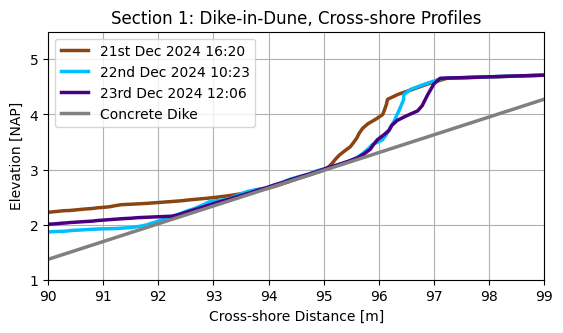

Surface under the line for df1: 21.349349679236894 m^2
Surface under the line for df2: 19.560455677961965 m^2
Surface under the line for df5: 19.36120011267453 m^2

surface_df1 - surface_df2: 1.7888940012749295 m^2
surface_df1 - surface_df5: 1.9881495665623632 m^2
surface_df2 - surface_df5: 0.1992555652874337 m^2


In [34]:
# Plot the transformed transects
plt.figure()

# Plot each dataframe
plt.plot(df1['x'], df1['z'], color='saddlebrown', linewidth=2.5, label='21st Dec 2024 16:20')
plt.plot(df2['x'], df2['z'], color='deepskyblue', linewidth=2.5, label='22nd Dec 2024 10:23')
plt.plot(df5['x'], df5['z'], color='indigo', linewidth=2.5, label='23rd Dec 2024 12:06')

# add line between toe(88.2,1.08) and top (97.5,4.77)
x = [89.1, 100.1]
y = [1.08, 4.63]
plt.plot(x, y, color='grey', linewidth=2.5, label='Concrete Dike')

plt.xlabel('Cross-shore Distance [m]')
plt.ylabel('Elevation [NAP]')
plt.title('Section 1: Dike-in-Dune, Cross-shore Profiles')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper left')
plt.xlim(90, 99)
plt.ylim(1, 5.5)
plt.show()



# Calculate surface under the lines from x(90, 99)
x1 = 90
x2 = 99
df1_mask = df1[(df1['x'] >= x1) & (df1['x'] <= x2)]
df2_mask = df2[(df2['x'] >= x1) & (df2['x'] <= x2)]
df5_mask = df5[(df5['x'] >= x1) & (df5['x'] <= x2)]

# Calculate the surface under the lines using the trapezoidal rule
surface_df1 = np.trapz(df1_mask['z'], df1_mask['x'])
surface_df2 = np.trapz(df2_mask['z'], df2_mask['x'])
surface_df5 = np.trapz(df5_mask['z'], df5_mask['x'])

print(f"Surface under the line for df1: {surface_df1} m^2")
print(f"Surface under the line for df2: {surface_df2} m^2")
print(f"Surface under the line for df5: {surface_df5} m^2")
print()
print(f'surface_df1 - surface_df2: {surface_df1 - surface_df2} m^2')
print(f'surface_df1 - surface_df5: {surface_df1 - surface_df5} m^2')
print(f'surface_df2 - surface_df5: {surface_df2 - surface_df5} m^2')
